# Leakage pattern deconvolution

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import leakagelib

SOURCE_SIZE = 55 # pixels # 41
IMAGE_SIZE = 2.8 # arcsec # 4
PIXEL_SIZE = 2.8 # arcsec # 4

SPECTRUM = leakagelib.Spectrum.from_power_law_index(2)

>>> Using cached xEffectiveArea object at /opt/homebrew/anaconda3/lib/python3.12/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d1_obssim20240101_v013.arf...


In [2]:
print(leakagelib)

<module 'leakagelib' from '/Users/jtd/Documents/research/ixpepl/code/leakagelib/src/leakagelib/__init__.py'>


This code uses an iterative method to deconvolve leakage patterns from an image. There's no method yet for error bar estimation; for that, use simultaneous fitting or LeakageLib's polarimetric fitting.

Suppose we have observed the following I, Q, U images:

In [3]:
mock_is = np.load("data/prediction/mock_is.npy")
mock_qs = np.load("data/prediction/mock_qs.npy")
mock_us = np.load("data/prediction/mock_us.npy")

Now we load the source, with the flux map stored in `data/prediction/pwn-i.fits`.

In [4]:
source = leakagelib.Source.load_file("data/prediction/pwn-i.fits", False, SOURCE_SIZE, PIXEL_SIZE)

Also load the PSFs for use in de-convolving the image.

In [5]:
psfs = []
for det in range(1,4):
    psfs.append(leakagelib.PSF.sky_cal(det, source, det * np.pi / 3 * 2))

The deconvolving code is stored in `fit_extended`, which has several meta-parameters. We'll run it and save the animation to `figs/animation.gif`

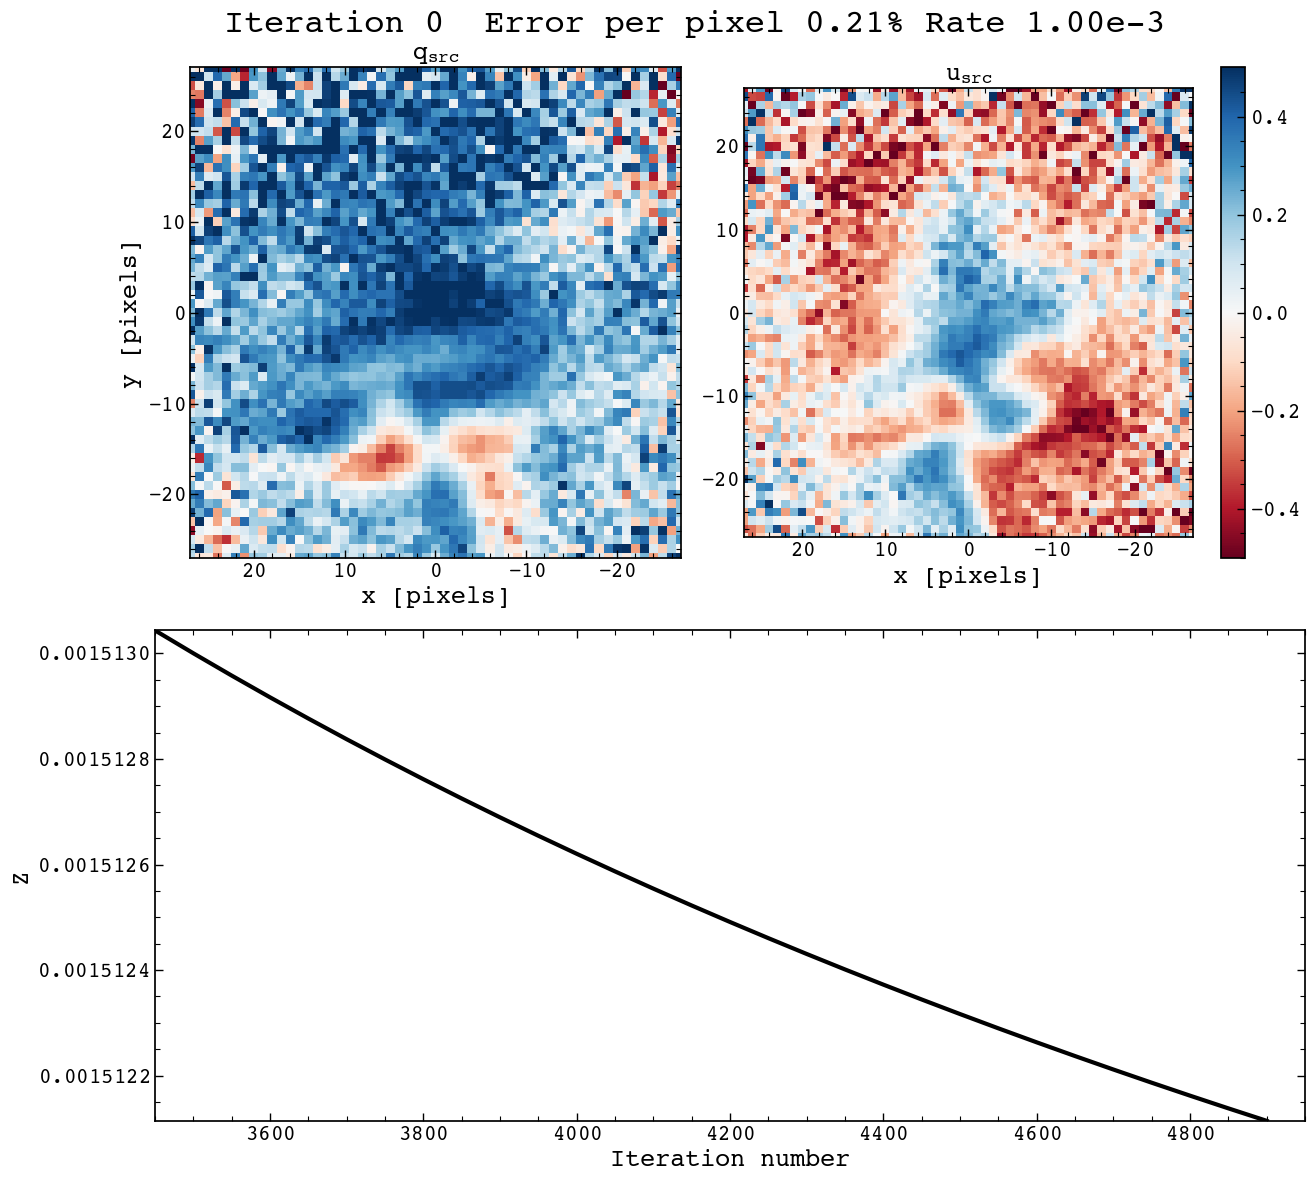

In [6]:
if not os.path.exists("figs"): os.mkdir("figs")

# Perform the fit
extracted_q, extracted_u, anim = leakagelib.extended.fit_extended(
    source, psfs, SPECTRUM,                                     # Properties of the source
    mock_is, mock_qs, mock_us,                                  # Leakage-containing observations
    initial_source_pol=None,                                    # Use the default starting point for the fitter
    inertia=None,                                               # Optional argument to prevent some pixels from being numerically unstable
    num_iter=5000, max_rate=2e-2, regularize_coeff=0.4,         # Fitter settings
    report_frequency=50,                                        # Saves a snapshot every frame. Set to None to improve speed
)

# Save the gif
if not os.path.exists("figs"):
    os.mkdir("figs")
if anim is not None:
    anim.save(f"figs/animation.gif")

Check out animation.gif for the fitter's progression over time. Now we'll tell the source the true polarization...

In [8]:
source.polarize_file("data/prediction/pwn-qu.fits") # Reset to the true polarization

... and compare the result to the deconvolved image.

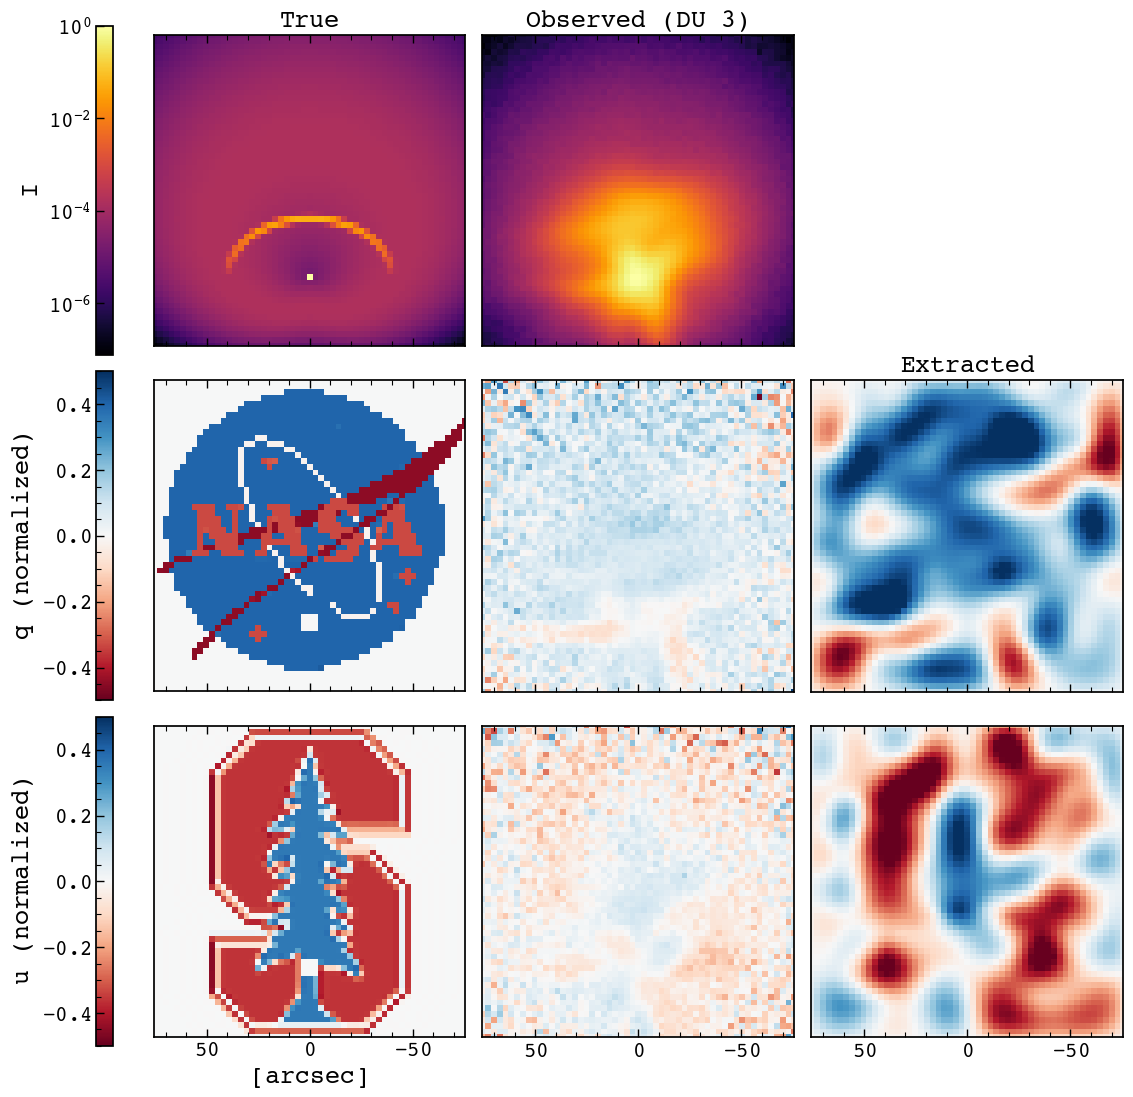

In [12]:
VMAX = 0.5
fig, axs = plt.subplots(figsize=(13, 12), ncols=3, nrows=3, sharex=True, sharey=True, gridspec_kw=dict(width_ratios=(1.33, 1, 1)))
c_i = axs[0,0].pcolormesh(source.pixel_centers, source.pixel_centers, source.source, norm=mpl.colors.LogNorm())
axs[0,1].pcolormesh(source.pixel_centers, source.pixel_centers, mock_is[2], norm=mpl.colors.LogNorm())
axs[0,2].axis(False)
c_qu = axs[1,0].pcolormesh(source.pixel_centers, source.pixel_centers, source.q_map, vmax=VMAX, vmin=-VMAX, cmap="RdBu")
axs[1,1].pcolormesh(source.pixel_centers, source.pixel_centers, mock_qs[2], vmax=VMAX, vmin=-VMAX, cmap="RdBu")
axs[1,2].pcolormesh(source.pixel_centers, source.pixel_centers, extracted_q, vmax=VMAX, vmin=-VMAX, cmap="RdBu")
axs[2,0].pcolormesh(source.pixel_centers, source.pixel_centers, source.u_map, vmax=VMAX, vmin=-VMAX, cmap="RdBu")
axs[2,1].pcolormesh(source.pixel_centers, source.pixel_centers, mock_us[2], vmax=VMAX, vmin=-VMAX, cmap="RdBu")
axs[2,2].pcolormesh(source.pixel_centers, source.pixel_centers, extracted_u, vmax=VMAX, vmin=-VMAX, cmap="RdBu")

for ax in axs.reshape(-1):
    ax.set_aspect("equal")
    ax.set_xlim(source.pixel_centers[-1], source.pixel_centers[0])
    ax.set_ylim(source.pixel_centers[0], source.pixel_centers[-1])
axs[2,0].set_xlabel("[arcsec]")

axs[0,0].set_title("True")
axs[0,1].set_title("Observed (DU 3)")
axs[1,2].set_title("Extracted")

axs[0,0].set_yticks([])
axs[1,0].set_yticks([])
axs[2,0].set_yticks([])

fig.colorbar(c_i , ax=axs[0,0], location='left', label="$I$")
fig.colorbar(c_qu, ax=axs[1,0], location='left', label="$q$ (normalized)")
fig.colorbar(c_qu, ax=axs[2,0], location='left', label="$u$ (normalized)")

fig.subplots_adjust(hspace=0.05, wspace=0.05)